In [1]:
# Import system packages
import os
import sys
import time
import logging
import importlib
from calendar import day_abbr, month_abbr

#Import data manipulation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from tqdm import tqdm

from imblearn.combine import SMOTEENN

#Import visualization libraries
import matplotlib.pyplot as plt

#Importing ML/DL libraries
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score

from keras import initializers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
import pickle

import tensorflow as tf

import random
random.seed(123)

from network import *
from train_utils import *

data_path = '../data/'

## Initialize parameters

current_dataset
* Select the current dataset to perform calculations on, choose either one_day, one_week or one_month

pickle_dataset
* true or false, choose if you want the currently loaded file to be pickled (or repickled if it already exists)

In [2]:
current_dataset = 'one_week'
pickle_dataset = False

Reads the anomaly labeled dataset and splits it into three minor dataframes containing data from one day, one week and one month.

In [5]:
df = pd.read_csv(f'{data_path}anomaly_labeled_dataset.csv' ,index_col=0)

df_one_day = df[df['dayofweek'] == 5]
df_one_day = df_one_day[df_one_day['dayofmonth'] == 7]
df_one_day = df_one_day[df_one_day['monthofyear'] == 7]
df_one_day = df_one_day[df_one_day['year'] == 2012]

df_one_week = df[df['monthofyear'] == 7]
df_one_week = df_one_week[df_one_week['year'] == 2012]
df_one_week = df_one_week[(df_one_week['dayofmonth'] >=1) & (df_one_week['dayofmonth'] <= 7)]

df_one_month = df[df['monthofyear'] == 7]
df_one_month = df_one_month[df_one_month['year'] == 2012]

df.head()

,costumer,GC,hourofday,minuteofhour,dayofweek,dayofmonth,monthofyear,year,Anomaly
0,7,0.580,0,0,4,1,7,2011,0
1,7,0.083,0,30,4,1,7,2011,0
2,7,0.156,1,0,4,1,7,2011,0
3,7,0.097,1,30,4,1,7,2011,0
4,7,0.058,2,0,4,1,7,2011,0


In [8]:
#df_one_day.head()
df['dayofweek'] == 5

0         False
1         False
2         False
3         False
4         False
          ...  
350875    False
350876    False
350877    False
350878    False
350879    False
Name: dayofweek, Length: 350880, dtype: bool

In [166]:
df.dtypes

costumer          int64
GC              float64
hourofday         int64
minuteofhour      int64
dayofweek         int64
dayofmonth        int64
monthofyear       int64
year              int64
Anomaly           int64
dtype: object

In [167]:
df.var()

costumer              6,208.1776932
GC                        0.0833110
hourofday                47.9168032
minuteofhour            225.0006412
dayofweek                 4.0026800
dayofmonth               77.5092420
monthofyear              11.8994353
year                      0.4993006
Anomaly                   0.0331603
dtype: float64

In [168]:
Enc = OrdinalEncoder()
df["year"] = Enc.fit_transform(df[["year"]]).astype('int64')
df[["year"]].value_counts()

year
1       175680
0        88320
2        86880
dtype: int64

In [169]:
Enc_1 = OrdinalEncoder()
df["costumer"] = Enc_1.fit_transform(df[["costumer"]]).astype('int64')
df[["costumer"]].value_counts()

costumer
9           35088
8           35088
7           35088
6           35088
5           35088
4           35088
3           35088
2           35088
1           35088
0           35088
dtype: int64

In [170]:
round(df.Anomaly.value_counts()/df.shape[0],3)*100

0             96.6000000
1              3.4000000
Name: Anomaly, dtype: float64

In [171]:
Imbalance_ratio=round(df.Anomaly[df.Anomaly==1].shape[0]/df.Anomaly[df.Anomaly==0].shape[0],3)
Imbalance_ratio

0.036

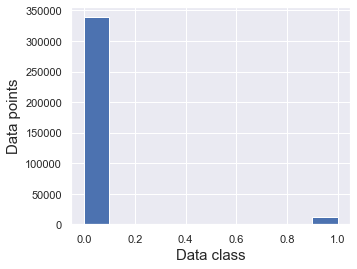

In [172]:
df['Anomaly'].hist(figsize=(5,4))
plt.xlabel('Data class',fontsize=15)
plt.ylabel('Data points',fontsize=15)
plt.show()

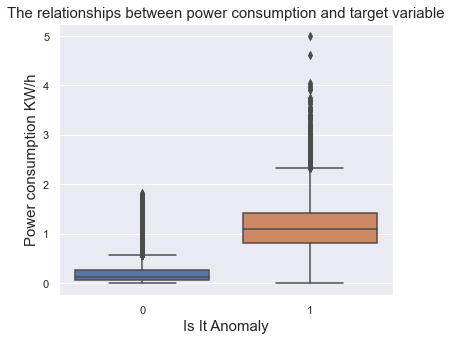

In [173]:
ax = sns.boxplot(x='Anomaly', y='GC', data=df)
sns.set(rc={'figure.figsize':(6,5)})
ax.set_xlabel('Is It Anomaly', fontsize=15)
ax.set_ylabel('Power consumption KW/h', fontsize=15)
plt.title('The relationships between power consumption and target variable', fontsize=15)
plt.show()

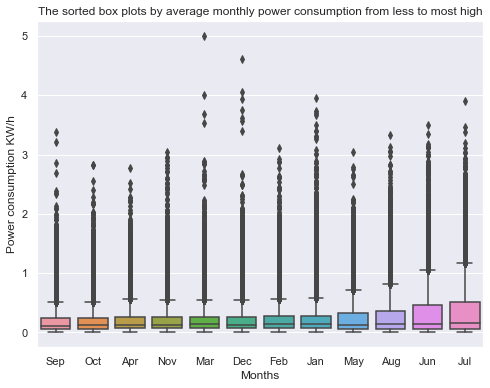

In [174]:
plt.figure(figsize=(8,6))
sorted_values = df.groupby(['monthofyear'])['GC'].mean().sort_values()
ax = sns.boxplot(x=df['monthofyear'], y=df['GC'], order=list(sorted_values.index))
months = [month_abbr[i] for i in sorted_values.index.values]
ax.set_xticklabels(months)
ax.set(xlabel='Months', ylabel='Power consumption KW/h')
plt.title('The sorted box plots by average monthly power consumption from less to most high')
plt.show()

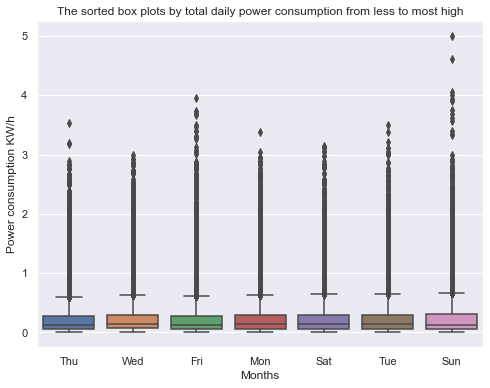

In [175]:
plt.figure(figsize=(8,6))
sorted_values = df.groupby(['dayofweek'])['GC'].sum().sort_values()
ax = sns.boxplot(x=df['dayofweek'], y=df['GC'], order=list(sorted_values.index))
days = [day_abbr[i] for i in sorted_values.index.values]
ax.set_xticklabels(days)
ax.set(xlabel='Months', ylabel='Power consumption KW/h')
plt.title('The sorted box plots by total daily power consumption from less to most high')
plt.show()

<AxesSubplot:xlabel='GC', ylabel='Count'>

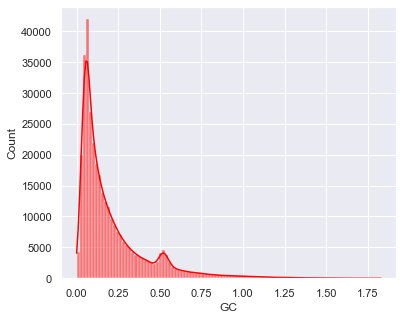

In [176]:
sns.histplot(df.GC[df.Anomaly == 0], kde=True, color='red', bins=100)

In [177]:
print("Mean:",round(df.GC[df.Anomaly == 0].mean(),3),"\nMedian",df.GC[df.Anomaly == 0].median(),
      "\nMode",df.GC[df.Anomaly == 0].mode()[0],"\nStandard deviation",round(df.GC[df.Anomaly == 0].std(),3))

Mean: 0.209 
Median 0.128 
Mode 0.055999999999999994 
Standard deviation 0.216


<AxesSubplot:xlabel='GC', ylabel='Count'>

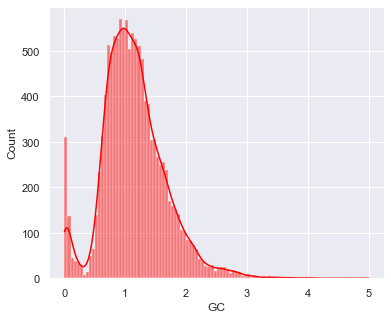

In [178]:
sns.histplot(df.GC[df.Anomaly == 1], kde=True, color='red', bins=100)

Uses the sklearn `train_test_split` method to extract x_train, x_test, y_train and y_test from the current dataset.

In [210]:
if current_dataset == 'one_day':
    current_dataset = df_one_day
elif current_dataset == 'one_week':
    current_dataset = df_one_week
elif current_dataset == 'one_month':
    current_dataset = df_one_month

# x_train, x_test, y_train, y_test = train_test_split(current_dataset.loc[:, ~current_dataset.columns.isin(['Anomaly'])], current_dataset.Anomaly,
#                                                     test_size=0.3, random_state=4,stratify=current_dataset.Anomaly,shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(current_dataset.loc[:, ~current_dataset.columns.isin(['Anomaly'])], current_dataset.Anomaly,
                                                    test_size=0.3,shuffle=False)

In [211]:
current_dataset

,costumer,GC,hourofday,minuteofhour,dayofweek,dayofmonth,monthofyear,year,Anomaly
17568,7,0.0870000,0,0,6,1,7,2012,0
17569,7,0.0980000,0,30,6,1,7,2012,0
17570,7,0.0640000,1,0,6,1,7,2012,0
17571,7,0.0890000,1,30,6,1,7,2012,0
17572,7,0.0670000,2,0,6,1,7,2012,0
...,...,...,...,...,...,...,...,...,...
333691,215,0.2300000,21,30,5,7,7,2012,0
333692,215,0.2530000,22,0,5,7,7,2012,0
333693,215,0.2760000,22,30,5,7,7,2012,0
333694,215,0.0630000,23,0,5,7,7,2012,0


In [212]:
y_test

263184    0
263185    0
263186    0
263187    0
263188    0
         ..
333691    0
333692    0
333693    0
333694    0
333695    0
Name: Anomaly, Length: 1008, dtype: int64

In [213]:
print("Train set size:",x_train.shape,"\nTest set size:",x_test.shape)

Train set size: (2352, 8) 
Test set size: (1008, 8)


In [214]:
# Check that all train set, validate set and test set has the same percentage of the positive class
print("Train set:\n",round(y_train.value_counts()/y_train.shape[0],3)*100)
print("Test set:\n",round(y_test.value_counts()/y_test.shape[0],3)*100)

Train set:
 0             90.9000000
1              9.1000000
Name: Anomaly, dtype: float64
Test set:
 0             89.8000000
1             10.2000000
Name: Anomaly, dtype: float64


In [215]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Creating dataset dictionary 
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

Resample dataset according to SMOTEENN (Combines over- and under sampling using SMOTE and Edited Nearest Neighbors)

In [216]:
sme = SMOTEENN(sampling_strategy='all')
resample_x, resample_y = sme.fit_resample(x_train, y_train)
resampled_dataset = {}
resampled_dataset['x_train'] = resample_x.astype(np.float32)
resampled_dataset['y_train'] = resample_y.astype(np.float32)
resampled_dataset['x_test']  = x_test.astype(np.float32)
resampled_dataset['y_test']  = y_test.astype(np.float32)

Pickles files if `pickle_files` variable is set to True

In [217]:
if pickle_files:

    if current_dataset == 'one_day':
        filename = 'dataset_one_day_not_shuffled.pkl'
    elif current_dataset == 'one_week':
        filename = 'dataset_one_week_not_shuffled.pkl'
    else:
        filename = 'dataset_one_month_not_shuffled.pkl'

    with open(filename, 'wb') as f:
        pickle.dump(resampled_dataset, f)

In [218]:
# check how many anomalies are in our Testing set
print('Number of Normal Network packets in the Training set:', x_train.shape[0])
print('Number of Normal Network packets in the Testing set:', collections.Counter(y_test)[0])
print('Number of Anomalous Network packets in the Testing set:', collections.Counter(y_test)[1])

Number of Normal Network packets in the Training set: 2352
Number of Normal Network packets in the Testing set: 905
Number of Anomalous Network packets in the Testing set: 103


# Find best hyperparameters
Warning: using this function will take a very long time

In [219]:
def find_hyperparameters():
    learning_rates = [0.01, 0.001, 0.0001, 0.00001]
    batch_sizes = [128, 256, 512, 1024]
    epochs = [5, 10, 15]

    parameters = []
    acc_scores = []
    precisions = []
    recalls = []
    f1s = []

    progress = tqdm(total=len(learning_rates)*len(batch_sizes)*len(epochs))

    for learning_rate in learning_rates:
        adam = Adam(learning_rate=learning_rate, beta_1 = 0.5)
        generator = get_generator(adam)
        discriminator = get_discriminator(adam)
        gan = get_gan_network(discriminator, generator, adam, input_dim=8)

        for batch_size in batch_sizes:
            for epoch in epochs:
                progress.update(1)

                discriminator_loss, gan_loss = train(x_train, batch_size, epoch, generator, discriminator, gan)
                y_pred = anomaly_detection(x_test, y_test, batch_size, discriminator)
                acc_score, precision, recall, f1 = evaluation(y_test, y_pred)

                parameters.append((learning_rate, batch_size, epoch))    
                acc_scores.append(acc_score)
                precisions.append(precision)
                recalls.append(recall)
                f1s.append(f1)
    
    max_acc = acc_scores.index(max(acc_scores))
    max_prec = precisions.index(max(precisions))
    max_rec = recalls.index(max(recalls))
    max_f1 = f1s.index(max(f1s))

    print(f'highest accuracy score: {acc_scores[max_acc]}\n\tlearning rate: {parameters[max_acc][0]}\n\tbatch_size: {parameters[max_acc][1]}\n\tepochs: {parameters[max_acc][2]}')
    print(f'\nhighest precision: {precisions[max_prec]}\n\tlearning rate: {parameters[max_prec][0]}\n\tbatch_size: {parameters[max_prec][1]}\n\tepochs: {parameters[max_prec][2]}')
    print(f'\nhighest recall: {recalls[max_rec]}\n\tlearning rate: {parameters[max_rec][0]}\n\tbatch_size: {parameters[max_rec][1]}\n\tepochs: {parameters[max_rec][2]}')
    print(f'\nhighest f1: {f1s[max_f1]}\n\tlearning rate: {parameters[max_f1][0]}\n\tbatch_size: {parameters[max_f1][1]}\n\tepochs: {parameters[max_f1][2]}')

"""Uncomment to run"""
# parameters, acc_scores, precisions, recalls, f1s = find_hyperparameters()

'Uncomment to run'

Runs both training and anomaly detection on the dataset, and plots loss, confusion matrix and ROC curve when done.

100%|██████████| 400/400 [00:34<00:00, 22.63it/s]

1008 1008


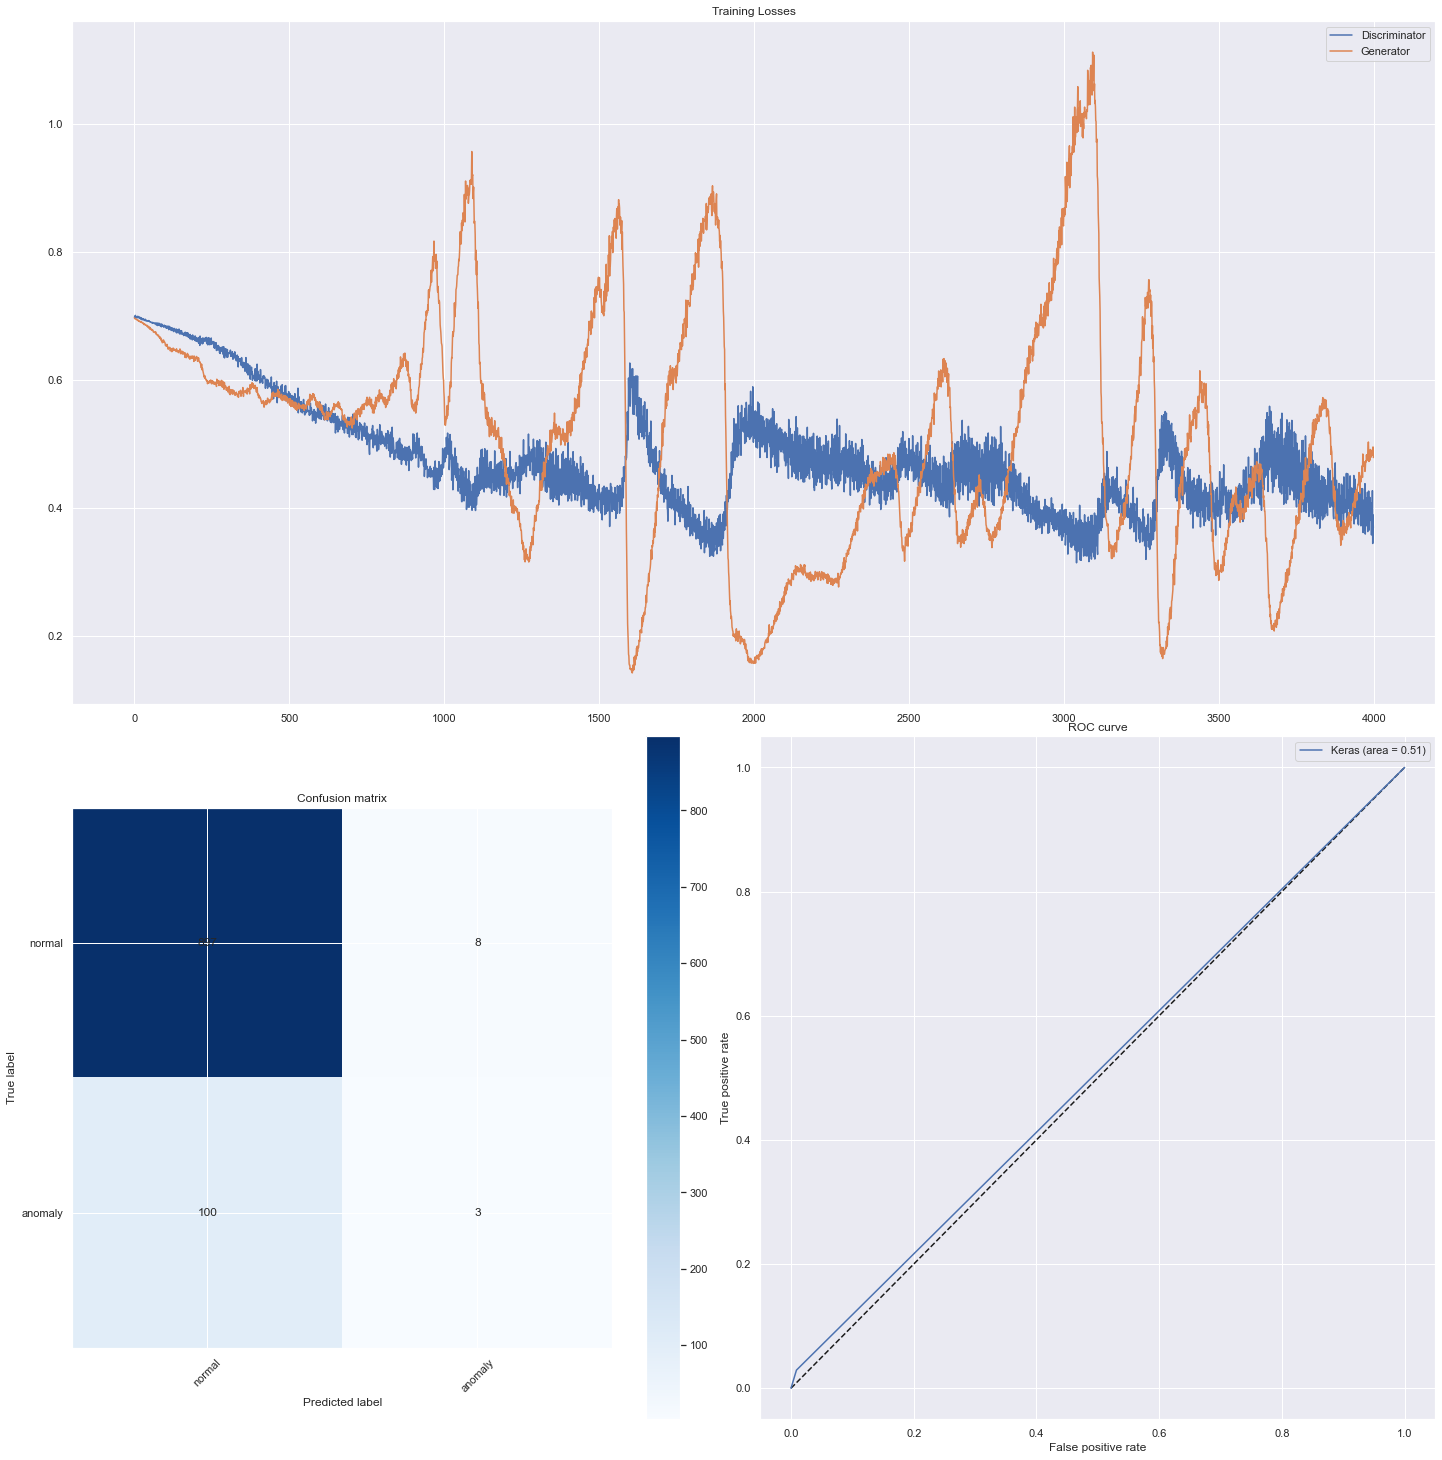

(array([0., 0., 0., ..., 0., 0., 0.]),
 <keras.engine.sequential.Sequential at 0x1c51ce76ac0>)

In [234]:
run_and_plot(dataset, 0.00001, 512, 1000, progress=True)

In [221]:
# run_and_plot(resampled_dataset, 0.00001, 512, 10, progress=True)

Runs and plots, and returns y_pred and trained_discriminator when done

1008 1008


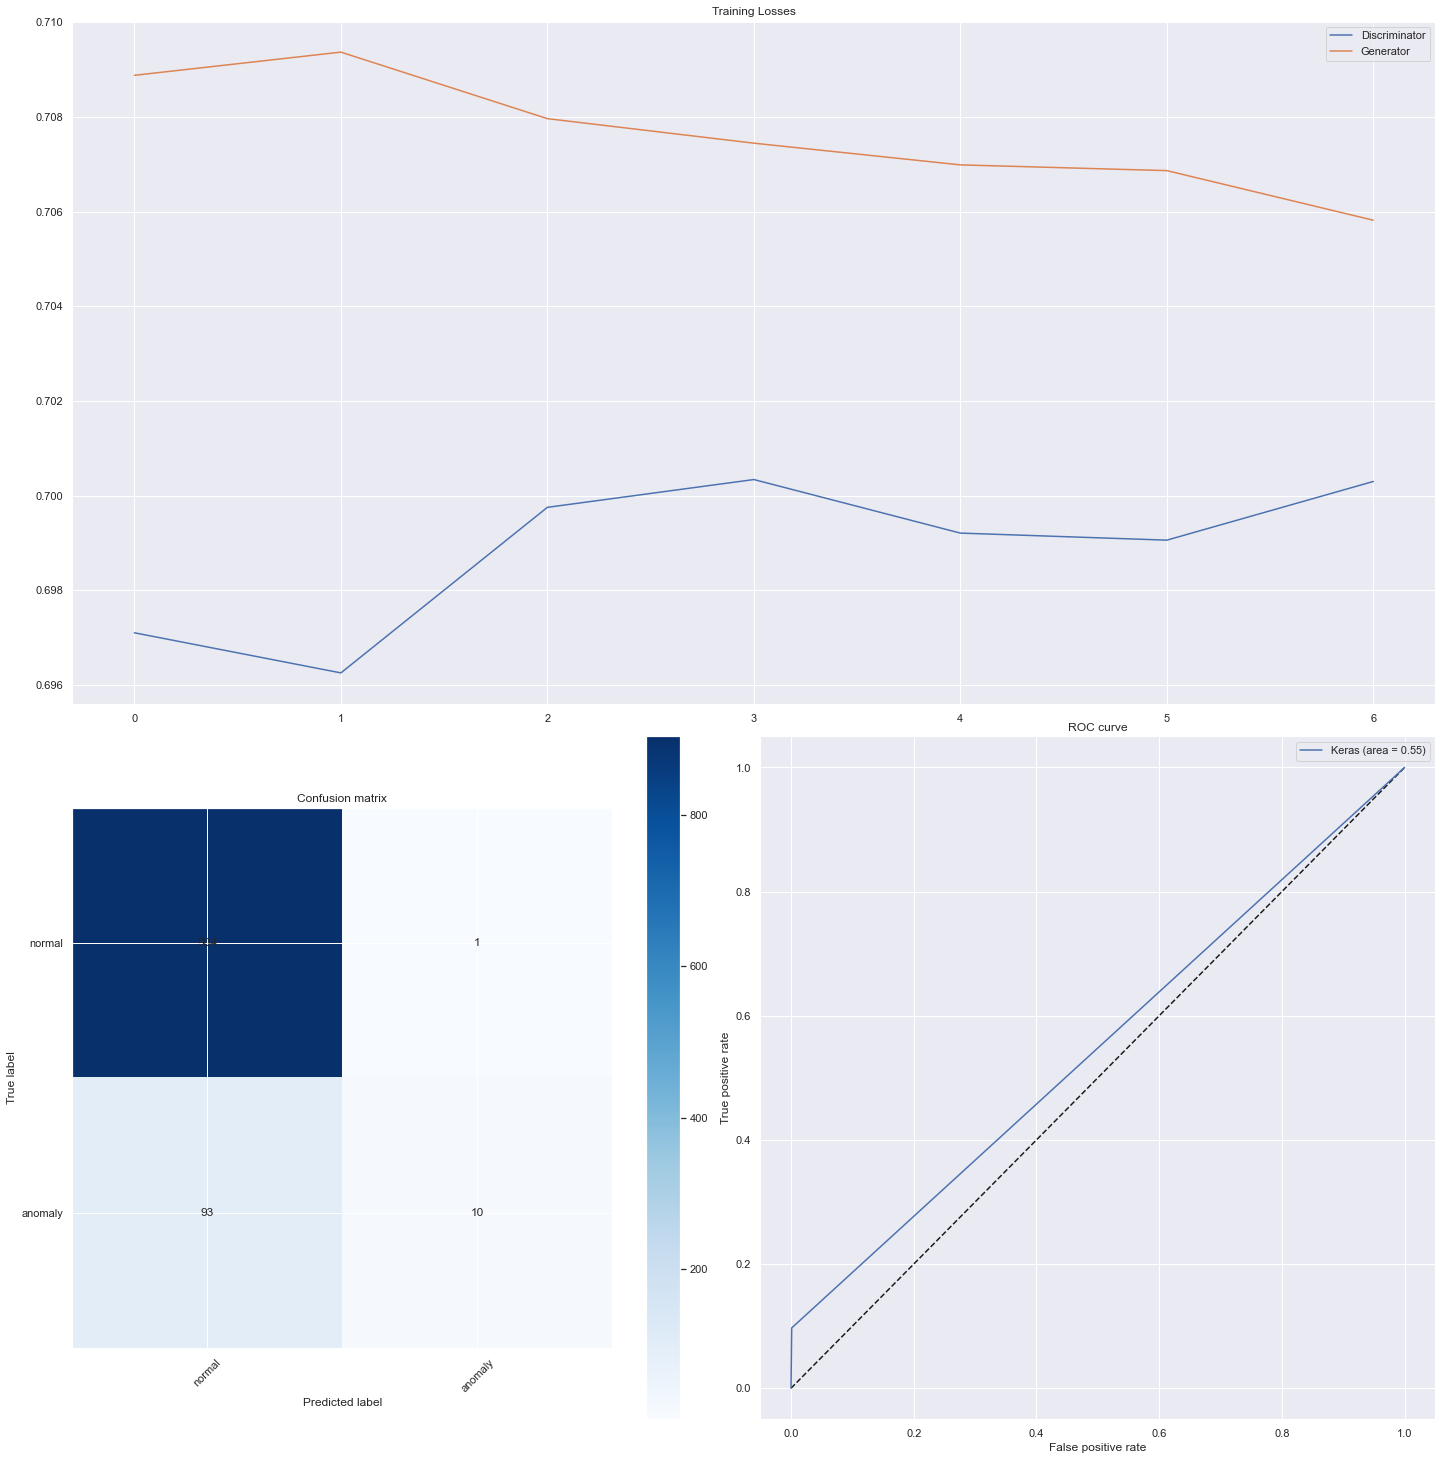

In [222]:
y_pred, trained_discriminator = run_and_plot(resampled_dataset, 0.00001, 512, 1, progress=True)

In [223]:
# df['timestamp'] = df['year'].astype(str) + '-' + df['monthofyear'].astype(str) + '-' + df['dayofmonth'].astype(str) + 'T' + df['hourofday'].astype(str) + ':' + df['minuteofhour'].astype(str) + ':00'
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df['Anomaly'] = y_pred

# df.head()

# plt.plot(df['timestamp'][:500], df['GC'][:500])

# for i in range(500):
#     if y_pred[i] == 1:
#         plt.axvspan(df['timestamp'].iloc[i-2], df['timestamp'].iloc[i+2], facecolor='red', alpha=0.2)

# plt.show()

100%|██████████| 40/40 [00:20<00:00, 20.61it/s]

Read and format the unlabeled 2012-2013 electricity data to a format equal to the "anomaly labeled data"

In [203]:
df_unlabeled = pd.read_csv(f'../data/2012-2013 Solar home electricity data v2.csv', skiprows=1, dayfirst=True, na_filter=False)
df_unlabeled = df_unlabeled[df_unlabeled['Customer'] == 1]
df_unlabeled = df_unlabeled[df_unlabeled['Consumption Category'] == 'GC']
df_unlabeled = df_unlabeled.drop(columns=['Consumption Category'])
df_unlabeled = df_unlabeled.drop(columns=['Postcode'])

df_unlabeled['date'] = pd.to_datetime(df_unlabeled['date'])
df_unlabeled['dayofweek'] = df_unlabeled['date'].dt.dayofweek
df_unlabeled['dayofmonth'] = df_unlabeled['date'].dt.day
df_unlabeled['monthofyear'] = df_unlabeled['date'].dt.month
df_unlabeled['year'] = df_unlabeled['date'].dt.year
df_unlabeled = df_unlabeled.drop(columns=['date'])

pivoted_df = pd.DataFrame(columns=['customer','GC', 'hourofday', 'minuteofhour', 'dayofweek', 'dayofmonth', 'monthofyear', 'year'])

idx = 0
for i, row in df_unlabeled.iterrows():
    for time in pd.date_range('0:00','23:59', freq='30min').format(formatter=lambda x:x.strftime('%#H:%M')):
        pivoted_df.loc[idx] = [row['Customer'], row[time], time.split(':')[0], time.split(':')[1], row['dayofweek'], row['dayofmonth'], row['monthofyear'], row['year']]
        idx += 1

pivoted_df = pivoted_df.astype({'customer':'int64', 'hourofday': 'int64', 'minuteofhour': 'int64', 'dayofweek': 'int64', 'dayofmonth': 'int64', 'monthofyear': 'int64', 'year': 'int64'})

pivoted_df.head()

,customer,GC,hourofday,minuteofhour,dayofweek,dayofmonth,monthofyear,year
0,1,0.0680000,0,0,5,7,1,2012
1,1,0.8550000,0,30,5,7,1,2012
2,1,0.7860000,1,0,5,7,1,2012
3,1,0.6040000,1,30,5,7,1,2012
4,1,0.5440000,2,0,5,7,1,2012


In [204]:
pivoted_df.dtypes

customer          int64
GC              float64
hourofday         int64
minuteofhour      int64
dayofweek         int64
dayofmonth        int64
monthofyear       int64
year              int64
dtype: object

In [205]:
scaler = MinMaxScaler()

one_day = pivoted_df.copy()

one_day = one_day[one_day['year'] == 2012]
one_day = one_day[one_day['dayofmonth'] == 7]
one_day = one_day[one_day['monthofyear'] == 1]

x_test = scaler.fit_transform(one_day)

Performs anomaly detection on the unlabeled dataset using the discriminator we got by training on the labeled dataset.

In [206]:
y_pred = test(x_test, 512, trained_discriminator)
print(y_pred.sum())

1.0


Formats dataframe to receive timestamp in a plottable format, and inserts the predicted anomaly list

In [207]:
one_day['timestamp'] = one_day['year'].astype(str) + '-' + one_day['monthofyear'].astype(str) + '-' + one_day['dayofmonth'].astype(str) + 'T' + one_day['hourofday'].astype(str) + ':' + one_day['minuteofhour'].astype(str) + ':00'
one_day['timestamp'] = pd.to_datetime(one_day['timestamp'])
one_day['Anomaly'] = y_pred

Plots the one_day data from the unlabeled dataset and adds lines representing detected anomalies

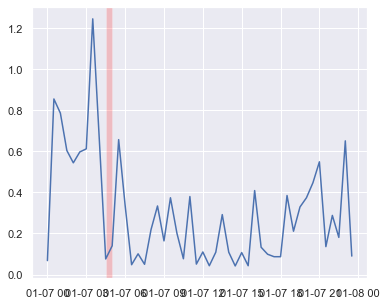

In [208]:
plt.plot(one_day['timestamp'], one_day['GC'])

for i, el in enumerate(y_pred):
    if el == 1:
        plt.axvspan(one_day['timestamp'][i], one_day['timestamp'][i+1], facecolor='red', alpha=0.2)

plt.show()

Does the same as above for one month on the unlabeled dataset.

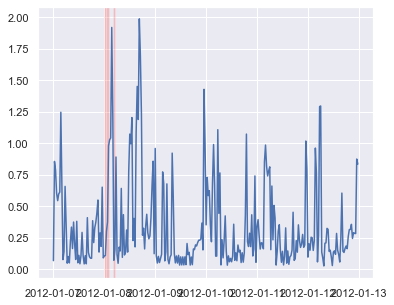

In [209]:
one_month = pivoted_df.copy()
one_month = one_month[one_month['year'] == 2012]
one_month = one_month[one_month['monthofyear'] == 1]
x_test = scaler.fit_transform(one_month)
y_pred = test(x_test, 512, trained_discriminator)
one_month['timestamp'] = one_month['year'].astype(str) + '-' + one_month['monthofyear'].astype(str) + '-' + one_month['dayofmonth'].astype(str) + 'T' + one_month['hourofday'].astype(str) + ':' + one_month['minuteofhour'].astype(str) + ':00'
one_month['timestamp'] = pd.to_datetime(one_month['timestamp'])
one_month['Anomaly'] = y_pred

plt.plot(one_month['timestamp'], one_month['GC'])
for i, el in enumerate(y_pred):
    if el == 1:
        plt.axvspan(one_month['timestamp'].iloc[i-1], one_month['timestamp'].iloc[i+1], facecolor='red', alpha=0.2)
plt.show()